In [1]:
import os
import glob
import shutil

import pandas as pd
import numpy as np
import pylab as pl
import seaborn as sns

import re
import scipy.stats as spstats
import json
from pipeline.python.classifications import experiment_classes as util

/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/experiment_classes.py:18: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
   

In [2]:
class struct():
    pass

def atoi(text):
    return int(text) if text.isdigit() else text

def natural_keys(text):
    return [ atoi(c) for c in re.split('(\d+)', text) ]

def label_figure(fig, data_identifier):                                                                                                                                     
    fig.text(0, 1,data_identifier, ha='left', va='top', fontsize=8)    

    

In [3]:
%matplotlib notebook

In [4]:
def load_traces(animalid, session, fovnum, curr_exp, traceid='traces001',
               responsive_test='ROC', responsive_thr=0.05, response_type='dff'):
    
    # Load experiment neural data
    fov = 'FOV%i_zoom2p0x' % fovnum
    if curr_exp=='blobs':
        exp = util.Objects(animalid, session, fov, traceid=traceid)
    else:
        exp = util.Gratings(animalid, session, fov, traceid=traceid)
    exp.load(trace_type='dff', update_self=True, make_equal=False)
    labels = exp.data.labels.copy()

    # Get stimulus config info
    sdf = exp.data.sdf
    if curr_exp == 'blobs':
        sdf = reformat_morph_values(sdf)
    n_conditions = len(sdf['size'].unique())

    # Get responsive cells
    responsive_cells, ncells_total = exp.get_responsive_cells(response_type=response_type,\
                                                              responsive_test=responsive_test,
                                                              responsive_thr=responsive_thr)
    
    traces = exp.data.traces[responsive_cells]

    return traces, labels, sdf

def reformat_morph_values(sdf):
    control_ixs = sdf[sdf['morphlevel']==-1].index.tolist()
    sizevals = np.array([round(s, 1) for s in sdf['size'].unique() if s not in ['None', None] and not np.isnan(s)] )
    sdf.loc[sdf.morphlevel==-1, 'size'] = pd.Series(sizevals, index=control_ixs)
    sdf['size'] = [round(s, 1) for s in sdf['size'].values]

    return sdf


In [5]:
def traces_to_trials(traces, labels):
    '''
    Returns dataframe w/ columns = roi ids, rows = mean response to stim ON per trial
    Last column is config on given trial.
    '''
    s_on = int(labels['stim_on_frame'].mean())
    n_on = int(labels['nframes_on'].mean())

    roi_list = traces.columns.tolist()
    trial_list = np.array([int(trial[5:]) for trial, g in labels.groupby(['trial'])])
    mean_responses = pd.DataFrame(np.vstack([np.nanmean(traces.iloc[g.index[s_on:s_on+n_on]], axis=0)\
                                        for trial, g in labels.groupby(['trial'])]),
                                         columns=roi_list, index=trial_list)

    condition_on_trial = np.array([g['config'].unique()[0] for trial, g in labels.groupby(['trial'])])
    mean_responses['config'] = condition_on_trial

    return mean_responses

# Get aggregate datasets

In [6]:
from pipeline.python.classifications import get_dataset_stats as gd
import cPickle as pkl

options = ['-t', 'traces001']
optsE = gd.extract_options(options)

rootdir = optsE.rootdir
aggregate_dir = optsE.aggregate_dir
fov_type = optsE.fov_type
traceid = optsE.traceid
response_type = 'dff'
print aggregate_dir

sdata_fpath = os.path.join(aggregate_dir, 'dataset_info.pkl')
if os.path.exists(sdata_fpath):
    with open(sdata_fpath, 'rb') as f:
        sdata = pkl.load(f)
else:
    sdata = gd.aggregate_session_info(traceid=optsE.traceid, trace_type=optsE.trace_type, 
                                       state=optsE.state, fov_type=optsE.fov_type, 
                                       visual_areas=optsE.visual_areas,
                                       blacklist=optsE.blacklist, 
                                       rootdir=optsE.rootdir)
    with open(sdata_fpath, 'wb') as f:
        pkl.dump(sdata, f, protocol=pkl.HIGHEST_PROTOCOL)

/n/coxfs01/julianarhee/aggregate-visual-areas


/home/julianarhee/Repositories/2p-pipeline/pipeline/python/classifications/get_dataset_stats.py:17: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to u'nbAgg' by the following code:
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/juliana

In [7]:
# Select response filters
responsive_test='ROC'
responsive_thr = 0.05
response_type = 'dff'
always_exclude = ['20190426_JC078']


In [8]:
#dsets = sdata[sdata['experiment']=='blobs'].copy()

incl_ixs = []
for dk, g in sdata.groupby(['animalid', 'session', 'fovnum']):
    if 'blobs' in g['experiment'].values and 'gratings' in g['experiment'].values:
        incl_ixs.extend(g.index.tolist())
        
dsets = sdata.loc[incl_ixs].copy()     
excluded_ixs = [i for i in dsets.index.tolist() for sk in always_exclude
                if (dsets.loc[i]['session']==sk.split('_')[0] and dsets.loc[i]['animalid']==sk.split('_')[1])]
included_ixs = [i for i in dsets.index.tolist() if i not in excluded_ixs]

dsets = dsets.loc[included_ixs]


In [9]:
g

,animalid,experiment,fov,session,visual_area,fovnum
109,JC120,rfs10,FOV1_zoom2p0x,20191111,Li,1
110,JC120,gratings,FOV1_zoom2p0x,20191111,Li,1
111,JC120,blobs,FOV1_zoom2p0x,20191111,Li,1
112,JC120,retino,FOV1_zoom2p0x,20191111,Li,1


In [10]:
dsets.groupby(['visual_area']).count()


,animalid,experiment,fov,session,fovnum
visual_area,,,,,
Li,49,49,49,49,49
Lm,24,24,24,24,24
V1,32,32,32,32,32


# Load other data

In [11]:
#### Load mean trial info for responsive cells
data_dir = os.path.join(aggregate_dir, 'data-stats')
os.listdir(data_dir)

#### BLOB DATA
load_blobs = False
blobsdata_outfile = os.path.join(data_dir, 'blobs_%s-%s_%s-thr-%.2f.pkl' % (traceid, response_type, responsive_test, responsive_thr))
print(blobsdata_outfile)
if os.path.exists(blobsdata_outfile):
    print("...loading data")
    with open(blobsdata_outfile, 'rb') as f:
        BLOBSDATA = pkl.load(f)
else:
    load_blobs = True
    
#### GRATINGS DATA
load_gratings = False
gratingsdata_outfile = os.path.join(data_dir, 'gratings_%s-%s_%s-thr-%.2f.pkl' % (traceid, response_type, responsive_test, responsive_thr))
print(gratingsdata_outfile)
if os.path.exists(gratingsdata_outfile):
    print("...loading data")
    with open(gratingsdata_outfile, 'rb') as f:
        GRATINGSDATA = pkl.load(f)
else:
    load_gratings = True

#### Load RF overlap info
luminance_dir = os.path.join(aggregate_dir, 'luminance-analysis')
overlaps_datafile = os.path.join(luminance_dir, 'overlaps-all-RFs.pkl')
assert os.path.exists(overlaps_datafile), "OVERLAPS NOT FOUND."
with open(overlaps_datafile, 'rb') as f:
    overlaprois = pkl.load(f)
    
print("Load blobs:", load_blobs)
print("Load gratings:", load_gratings)

/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/blobs_traces001-dff_ROC-thr-0.05.pkl
...loading data
/n/coxfs01/julianarhee/aggregate-visual-areas/data-stats/gratings_traces001-dff_ROC-thr-0.05.pkl
...loading data
('Load blobs:', False)
('Load gratings:', False)


In [12]:
if load_gratings or load_blobs:
    
    curr_exp = 'gratings' if load_gratings else 'blobs'
    data_outfile = gratingsdata_outfile if load_gratings else blobsdata_outfile 
    print("Getting data: %s" % curr_exp)
    print("Saving data to %s" % data_outfile)
    
    tmpdsets = sdata[sdata['experiment']==curr_exp]
    fovnums = [int(fv.split('_')[0][3:]) for fv in dsets['fov']]
    dsets['fovnum'] = fovnums

    DATA = {}
    for (animalid, session, fovnum), g in tmpdsets.groupby(['animalid', 'session', 'fovnum']):
        datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
        if '%s_%s' % (session, animalid) in always_exclude:
            continue

        # Load traces
        traces, labels, sdf = load_traces(animalid, session, fovnum, curr_exp, 
                                          traceid=traceid, response_type=response_type,
                                          responsive_test=responsive_test, responsive_thr=responsive_thr)
        # Calculate mean trial metric
        mean_responses = traces_to_trials(traces, labels)

        DATA['%s' % datakey] = {'data': mean_responses,
                                'sdf': sdf}
        
    # Save
    with open(data_outfile, 'wb') as f:
        pkl.dump(DATA, f, protocol=pkl.HIGHEST_PROTOCOL)
    print("Done!")
    

# Test 1 dataset

In [12]:
animalid = 'JC084'
session = '20190522'
fovnum = 1


In [13]:
curr_exp = 'gratings'

#### Load traces of responsive cells
traces, labels, sdf = load_traces(animalid, session, fovnum, curr_exp, traceid=traceid, response_type=response_type,
                                    responsive_test=responsive_test, responsive_thr=responsive_thr)
trial_key = dict((int(t[5:]), g['config'].unique()[0]) for t, g in labels.groupby(['trial']))
rois_objects = [int(r) for r in traces.columns.tolist()]


... [JC084|20190522|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... loading data array
/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/data_arrays/np_subtracted.npz
NP_subtracted offset was: 93.85
adding NP offset... (NP baseline offset: 611.99)
((110360, 260), (260,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC084/20190522/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_55a5cc_traces001_7eef99_traces001_809b80_traces001_fbc03e/summary_stats/ROC/roc_results.pkl']


In [14]:
sdf.head()

,aspect,direction,luminance,ori,position,sf,size,speed,stimtype,xpos,ypos
config001,1,0,None,0,"(0, 0)",0.1,200,10,gratings,0,0
config002,1,0,None,0,"(0, 0)",0.1,200,20,gratings,0,0
config003,1,0,None,0,"(0, 0)",0.5,200,10,gratings,0,0
config004,1,0,None,0,"(0, 0)",0.5,200,20,gratings,0,0
config005,1,0,None,0,"(20, -8)",0.1,20,10,gratings,20,-8


In [15]:
df = traces.copy()
df['trial'] = labels['trial'].copy()
df['config'] = labels['config'].copy()

mean_trace = np.nanmean(np.vstack([np.nanmean(g[rois_objects], axis=1) for t, g in df.groupby(['trial'])]), axis=0)
std_trace = spstats.sem(mean_trace, axis=0, nan_policy='omit')


In [18]:
labels['stim_on_frame'].unique(), labels['nframes_on'].unique()

(array([22], dtype=object), array([22], dtype=object))

<IPython.core.display.Javascript object>


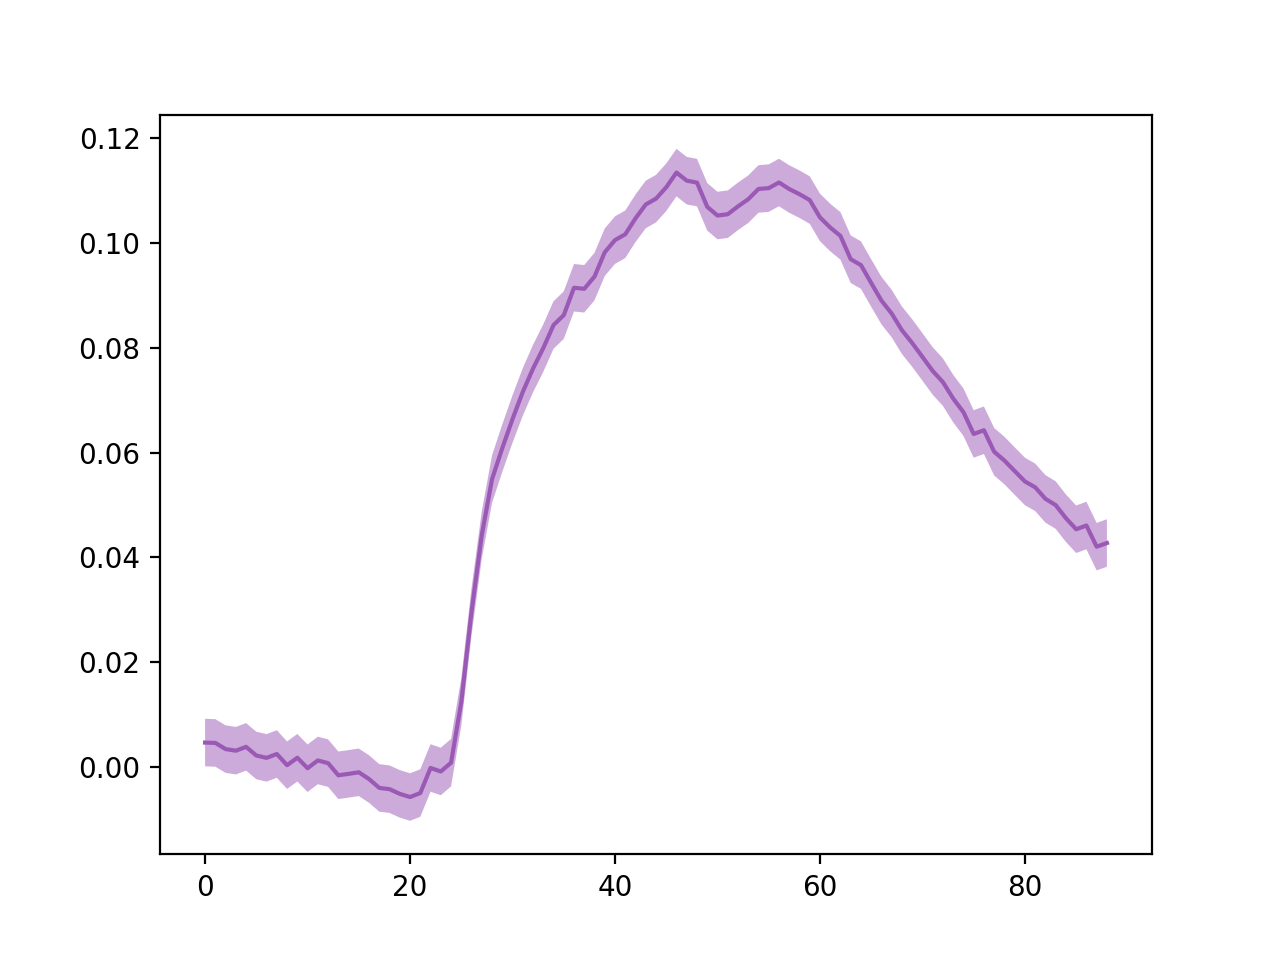

In [16]:
fig, ax = pl.subplots()

#grand_mean_trace = np.nanmean(mean_trace, axis=0)
#grand_std_trace = spstats.sem(mean_trace, axis=0, nan_policy='omit')
ax.plot(mean_trace)

nt = len(mean_trace)
ax.fill_between(np.arange(0, nt), mean_trace-std_trace, y2=mean_trace+std_trace, alpha=0.5)


# Set colors

In [39]:
visual_areas = ['V1', 'Lm', 'Li']
color_list = ['gray', 'cornflowerblue', 'darkorange']
area_colors = dict((v, c) for v, c in zip(visual_areas, color_list))

pl.rcParams["axes.labelsize"] = 16
pl.rcParams["xtick.labelsize"] = 12
pl.rcParams["ytick.labelsize"] = 12

# Set output dir

In [14]:
outdir = os.path.join(aggregate_dir, 'responsivity')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

figid = '%s_%s_%s-thr-%.2f' % (traceid, response_type, responsive_test, responsive_thr)
print(figid)

/n/coxfs01/julianarhee/aggregate-visual-areas/responsivity
traces001_dff_ROC-thr-0.05


### Filter out ROIs that have bad stim placement

In [52]:
overlap_thr = 0.20

passrois={}
roicounts=[]
i=0
for curr_exp in ['blobs', 'gratings']:

    for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
        datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
        
        if curr_exp == 'blobs':
            visual_rois = [int(r) for r in BLOBSDATA[datakey]['data'].columns if r != 'config']
        else:
            visual_rois = [int(r) for r in GRATINGSDATA[datakey]['data'].columns if r != 'config']

        # Get ROIs with RF fits and threshold by overlap-percentage
        meanoverlaps = overlaprois[overlaprois['datakey']==datakey].groupby(['rid']).mean()
        coverage_rois = meanoverlaps[meanoverlaps['overlap']>=overlap_thr].index.tolist()
        pass_rois_overlap = [r for r in coverage_rois if r in visual_rois]

        #print("RF-lum-thr: %i/%i, Overlap-thr: %i/%i" % (len(pass_rois_lum), len(lum_rois), len(pass_rois_overlap), len(coverage_rois)))
        #curr_rois = np.intersect1d(pass_rois_lum, pass_rois_overlap)
        #print("[%s, %s] %i rois common to both." % (visual_area, datakey, len(curr_rois))) 

        passrois[datakey] = pass_rois_overlap

        roicounts.append(pd.DataFrame({'visual': len(visual_rois),
                                       'experiment': curr_exp,
                                       'pass_overlap': len(pass_rois_overlap),
                                       'visual_area': visual_area,
                                       'datakey': datakey}, index=[i]))
        i+=1
roicounts = pd.concat(roicounts, axis=0)


<IPython.core.display.Javascript object>


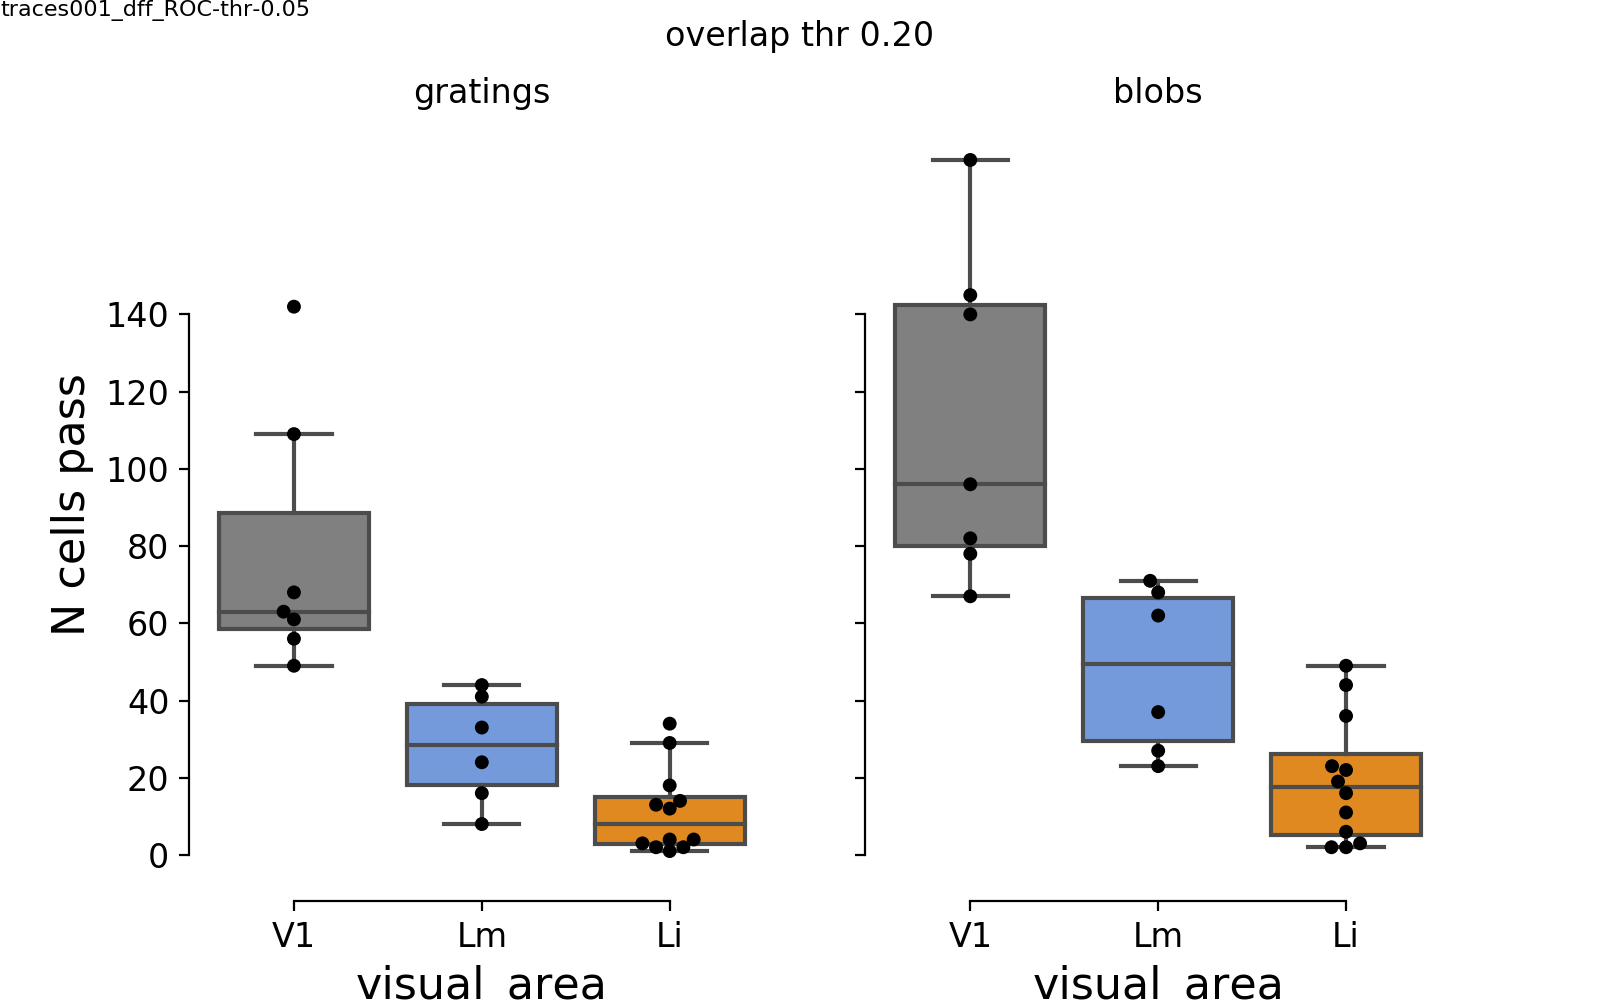

overlap-rois_thr-0.20_ROC


In [53]:

fig, axes = pl.subplots(1, 2, figsize=(8, 5), sharex=True, sharey=True)

curr_exp = 'gratings'
ax = axes[0]
ax.set_title(curr_exp)
sns.boxplot(x='visual_area', y='pass_overlap', data=roicounts[roicounts['experiment']==curr_exp], 
            ax=ax, palette=area_colors, order=visual_areas, fliersize=0)
sns.swarmplot(x='visual_area', y='pass_overlap', data=roicounts[roicounts['experiment']==curr_exp], 
              ax=ax, color='k', order=visual_areas)
sns.despine(trim=True, offset=4)
ax.set_ylabel("N cells pass")


curr_exp = 'blobs'
ax = axes[1]
ax.set_title(curr_exp)
sns.boxplot(x='visual_area', y='pass_overlap', data=roicounts[roicounts['experiment']==curr_exp], 
            ax=ax, palette=area_colors, order=visual_areas)
sns.swarmplot(x='visual_area', y='pass_overlap', data=roicounts[roicounts['experiment']==curr_exp], 
              ax=ax, color='k', order=visual_areas)
sns.despine(trim=True, offset=4)
ax.set_ylabel("")
pl.suptitle('overlap thr %.2f' % overlap_thr)


figname = 'overlap-rois_thr-%.2f_%s' % (overlap_thr, responsive_test)

label_figure(fig, figid)
print(figname)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
pl.savefig(os.path.join(outdir, '%s.png' % figname))

In [17]:
roicounts.head()

,datakey,experiment,pass_overlap,visual,visual_area
0,20190605_JC090_fov1,blobs,20,141,Li
1,20190602_JC091_fov1,blobs,52,161,Li
2,20190606_JC091_fov1,blobs,21,110,Li
3,20190607_JC091_fov1,blobs,40,133,Li
4,20190614_JC091_fov1,blobs,55,122,Li


In [54]:
roicounts['fraction_pass'] = roicounts['pass_overlap'] / roicounts['visual']
roicounts.head()

,datakey,experiment,pass_overlap,visual,visual_area,fraction_pass
0,20190605_JC090_fov1,blobs,11,141,Li,0.078014
1,20190602_JC091_fov1,blobs,49,161,Li,0.304348
2,20190606_JC091_fov1,blobs,19,110,Li,0.172727
3,20190607_JC091_fov1,blobs,36,133,Li,0.270677
4,20190614_JC091_fov1,blobs,44,122,Li,0.360656


<IPython.core.display.Javascript object>


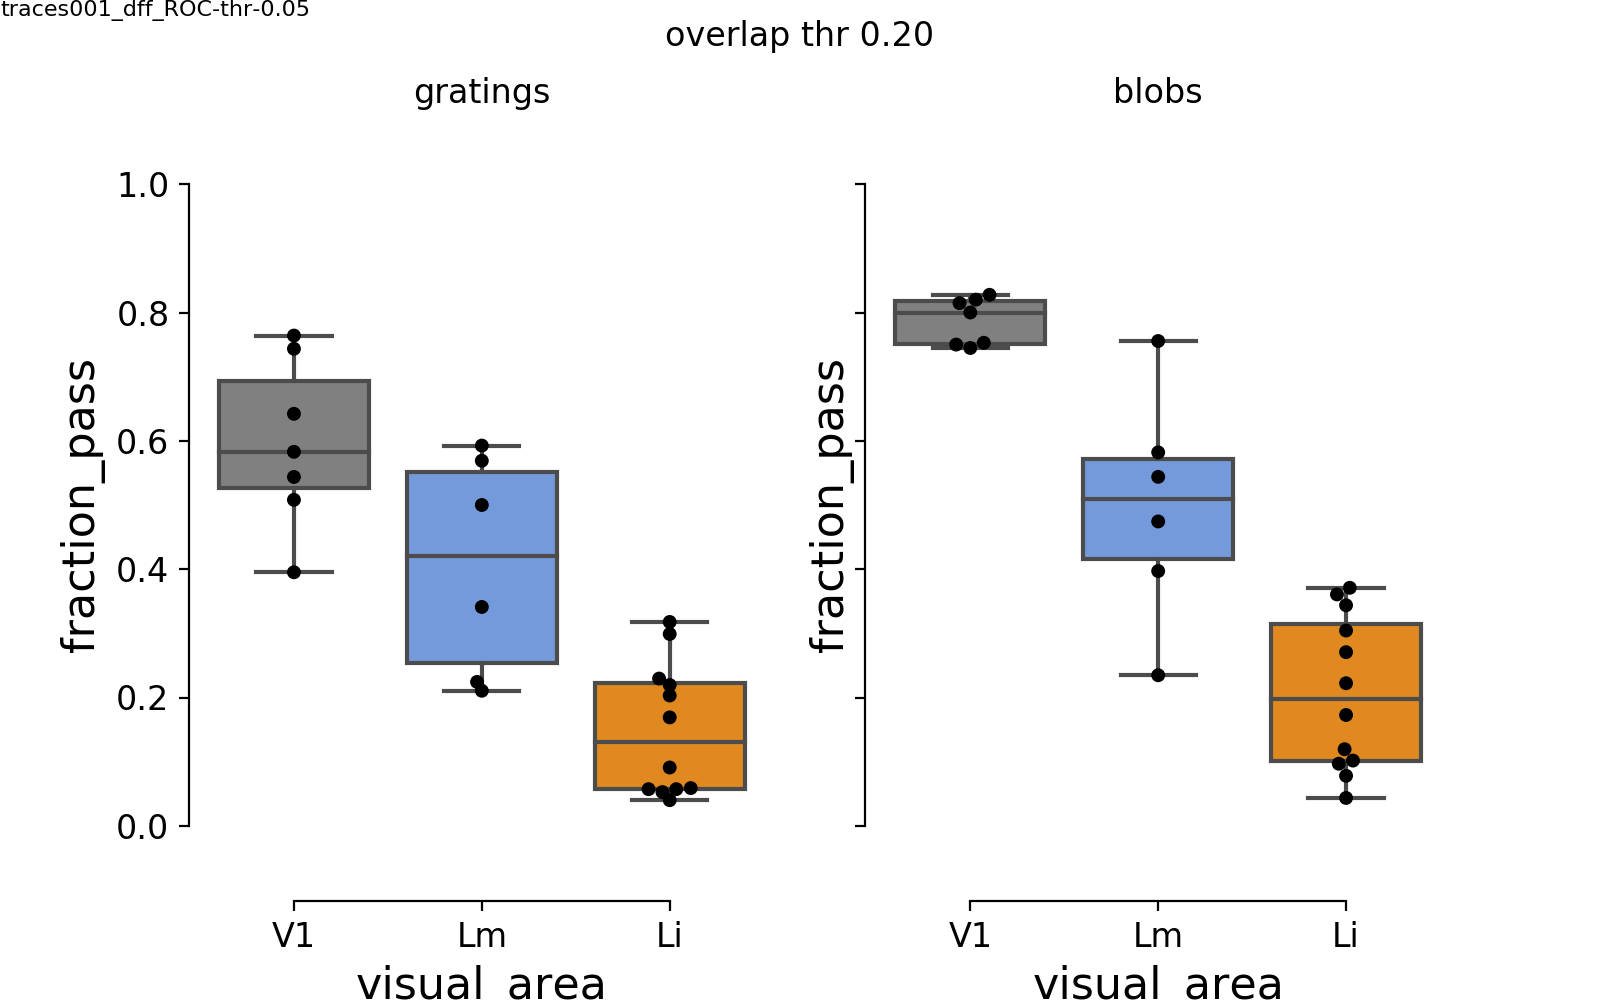

overlap-rois-frac_thr-0.20_ROC


In [55]:

fig, axes = pl.subplots(1, 2, figsize=(8, 5), sharex=True, sharey=True)

curr_exp = 'gratings'
ax = axes[0]
ax.set_title(curr_exp)
sns.boxplot(x='visual_area', y='fraction_pass', data=roicounts[roicounts['experiment']==curr_exp], ax=ax, 
            palette=area_colors, order=visual_areas, fliersize=0)
sns.swarmplot(x='visual_area', y='fraction_pass', data=roicounts[roicounts['experiment']==curr_exp], ax=ax, 
              color='k', order=visual_areas)
ax.set_ylim([-.1, 1.1])

curr_exp = 'blobs'
ax = axes[1]
ax.set_title(curr_exp)
sns.boxplot(x='visual_area', y='fraction_pass', data=roicounts[roicounts['experiment']==curr_exp], ax=ax, 
            palette=area_colors, order=visual_areas, fliersize=0)
sns.swarmplot(x='visual_area', y='fraction_pass', data=roicounts[roicounts['experiment']==curr_exp], ax=ax, 
              color='k', order=visual_areas)
ax.set_ylim([-.1, 1.1])
pl.suptitle('overlap thr %.2f' % overlap_thr)

sns.despine(trim=True, offset=4)
figname = 'overlap-rois-frac_thr-%.2f_%s' % (overlap_thr, responsive_test)

label_figure(fig, figid)
print(figname)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
pl.savefig(os.path.join(outdir, '%s.png' % figname))

# Load mean trace for all datasets

In [38]:
outdir

'/n/coxfs01/julianarhee/aggregate-visual-areas/responsivity'

In [ ]:
min_rois = 5
stim_on_key = {'blobs': 45, 'gratings': 45}
nframes_on_key = {'blobs':  45, 'gratings':  22}

tracedf = []
incorrect_alignment = {}
curr_exp = 'blobs'

for curr_exp in ['blobs', 'gratings']:
    stim_on = stim_on_key[curr_exp]
    nframes_on = nframes_on_key[curr_exp]
    for (visual_area, animalid, session, fovnum), g in dsets.groupby(['visual_area', 'animalid', 'session', 'fovnum']):
        datakey = '%s_%s_fov%i' % (session, animalid, fovnum)
        #### Load traces of responsive cells
        traces, labels, sdf = load_traces(animalid, session, fovnum, curr_exp, traceid=traceid, response_type=response_type,
                                            responsive_test=responsive_test, responsive_thr=responsive_thr)

        if labels['stim_on_frame'].unique()[0] != stim_on or labels['nframes_on'].unique()[0] != nframes_on:
            incorrect_alignment.update({'%s_%s' % (datakey, curr_exp): 
                                                  {'stim_on': float(labels['stim_on_frame'].unique()),
                                                  'nframes_on': float(labels['nframes_on'].unique())}})
            print("... %s: incorrect, skipping." % datakey)
            continue

        rois_objects = passrois[datakey] #[int(r) for r in traces.columns.tolist()]
        if len(rois_objects) < min_rois:
            print("%s: skipping, too few ROIs pass %.2f overlap thr" % (datakey, overlap_thr))
            continue

        df = traces.copy()
        df['trial'] = labels['trial'].copy()
        df['config'] = labels['config'].copy()

        mean_trace = np.nanmean(np.vstack([np.nanmean(g[rois_objects], axis=1) for t, g in df.groupby(['trial'])]), axis=0)
        nt = len(mean_trace)
        del df
        
        tracedf.append(pd.DataFrame({'trace': mean_trace,
                                   'visual_area': [visual_area for _ in np.arange(0, nt)],
                                   'datakey': [datakey for _ in np.arange(0, nt)],
                                    'experiment': [curr_exp for _ in np.arange(0, nt)]}))
tdf = pd.concat(tracedf, axis=0)

    

... [JC090|20190605|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading data array
/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5afb30_traces001_ea6bc7_traces001_9747d8_traces001_70031f_traces001_ba4282_traces001_c2eec5_traces001_5c088e/data_arrays/np_subtracted.npz
NP_subtracted offset was: 12.62
adding NP offset... (NP baseline offset: 524.29)
((220725, 271), (271,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC090/20190605/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_5afb30_traces001_ea6bc7_traces001_9747d8_traces001_70031f_traces001_ba4282_traces001_c2eec5_traces001_5c088e/summary_stats/ROC/roc_results.pkl']


/home/julianarhee/anaconda2/envs/pipeline/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: Mean of empty slice


... [JC091|20190602|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading data array
/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_573669_traces001_3d2687_traces001_17838a_traces001_452178_traces001_c84a17_traces001_faae98/data_arrays/np_subtracted.npz
NP_subtracted offset was: 62.93
adding NP offset... (NP baseline offset: 372.49)
((202365, 356), (356,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC091/20190602/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_573669_traces001_3d2687_traces001_17838a_traces001_452178_traces001_c84a17_traces001_faae98/summary_stats/ROC/roc_results.pkl']
... [JC091|20190606|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading data array
/n/coxfs01/2p-data/JC091/20190606/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_c8905e_traces001_cca83f_traces001_282089_

NP_subtracted offset was: -32.03
adding NP offset... (NP baseline offset: 169.75)
((202500, 190), (190,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC120/20191111/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_603e33_traces001_b209e8_traces001_0b0a19_traces001_67c45c_traces001_8513ce_traces001_12f240/summary_stats/ROC/roc_results.pkl']
20191111_JC120_fov1: skipping, too few ROIs pass 0.10 overlap thr
... [JC078|20190513|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading data array
/n/coxfs01/2p-data/JC078/20190513/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_23404b_traces001_f36dbe_traces001_ece5a1_traces001_c7edbd_traces001_ba61ae_traces001_1ef319/data_arrays/np_subtracted.npz
NP_subtracted offset was: 124.25
adding NP offset... (NP baseline offset: 595.74)
((199125, 280), (280,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05

NP_subtracted offset was: 224.97
adding NP offset... (NP baseline offset: 852.07)
((202500, 432), (432,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC097/20190616/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_d1a2cd_traces001_a13a76_traces001_0a4432_traces001_6fc2ca_traces001_2449cf_traces001_70650b/summary_stats/ROC/roc_results.pkl']
... [JC097|20190617|FOV1_zoom2p0x] creating blobs object
... getting data paths - name: blobs
... loading data array
/n/coxfs01/2p-data/JC097/20190617/FOV1_zoom2p0x/combined_blobs_static/traces/traces001_90a1e8_traces001_99c4ae_traces001_f2cdc2_traces001_f92243_traces001_c53295_traces001_7673a4/data_arrays/np_subtracted.npz
NP_subtracted offset was: 157.46
adding NP offset... (NP baseline offset: 853.19)
((199125, 438), (438,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_blobs_static
['/n/coxfs01/2p-data/JC097/2019

NP_subtracted offset was: 18.13
adding NP offset... (NP baseline offset: 913.85)
((143360, 102), (102,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-data/JC099/20190617/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_585a7e_traces001_864059_traces001_9119e0_traces001_eb3372/summary_stats/ROC/roc_results.pkl']
20190617_JC099_fov1: skipping, too few ROIs pass 0.10 overlap thr
... [JC113|20191018|FOV1_zoom2p0x] creating gratings object
... getting data paths - name: gratings
... loading data array
/n/coxfs01/2p-data/JC113/20191018/FOV1_zoom2p0x/combined_gratings_static/traces/traces001_2f9d54_traces001_4d8870_traces001_4ea429_traces001_4161fc/data_arrays/np_subtracted.npz
NP_subtracted offset was: 80.04
adding NP offset... (NP baseline offset: 1110.97)
((113920, 210), (210,), ())
... updating self
... getting responsive cells (test: ROC, thr: 0.05')
-- stats: combined_gratings_static
['/n/coxfs01/2p-

In [22]:
incorrect_alignment

{'20190511_JC083_fov1_gratings': {'nframes_on': 45.0, 'stim_on': 45.0},
 '20190512_JC083_fov1_blobs': {'nframes_on': 45.0, 'stim_on': 22.0},
 '20190512_JC083_fov1_gratings': {'nframes_on': 45.0, 'stim_on': 22.0},
 '20190513_JC078_fov1_gratings': {'nframes_on': 45.0, 'stim_on': 22.0},
 '20190517_JC083_fov1_gratings': {'nframes_on': 22.0, 'stim_on': 22.0},
 '20190522_JC084_fov1_gratings': {'nframes_on': 22.0, 'stim_on': 22.0},
 '20190525_JC084_fov1_gratings': {'nframes_on': 22.0, 'stim_on': 22.0},
 '20190602_JC091_fov1_gratings': {'nframes_on': 22.0, 'stim_on': 22.0},
 '20190603_JC080_fov1_gratings': {'nframes_on': 22.0, 'stim_on': 22.0},
 '20190605_JC090_fov1_gratings': {'nframes_on': 22.0, 'stim_on': 22.0},
 '20190607_JC091_fov1_gratings': {'nframes_on': 22.0, 'stim_on': 22.0},
 '20190609_JC099_fov1_gratings': {'nframes_on': 22.0, 'stim_on': 22.0},
 '20190612_JC099_fov1_gratings': {'nframes_on': 22.0, 'stim_on': 22.0},
 '20190614_JC091_fov1_gratings': {'nframes_on': 22.0, 'stim_on': 22

In [23]:
tdf.tail()

,datakey,experiment,trace,visual_area
107,20190617_JC097_fov1,gratings,0.028817,V1
108,20190617_JC097_fov1,gratings,0.028662,V1
109,20190617_JC097_fov1,gratings,0.028491,V1
110,20190617_JC097_fov1,gratings,0.027272,V1
111,20190617_JC097_fov1,gratings,0.026274,V1


### Plot average popn trace

In [34]:
curr_exp = 'blobs'

nframes_trial = stim_on_key[curr_exp]*2 + nframes_on_key[curr_exp]
print(nframes_trial)
traces_by = dict((visual_area, []) for visual_area in visual_areas)
#fig, ax = pl.subplots()
for (visual_area, dkey), g in tdf[tdf['experiment']==curr_exp].groupby(['visual_area', 'datakey']):
    traces_by[visual_area].append(g['trace'].values[0:nframes_trial])
    

135


<IPython.core.display.Javascript object>


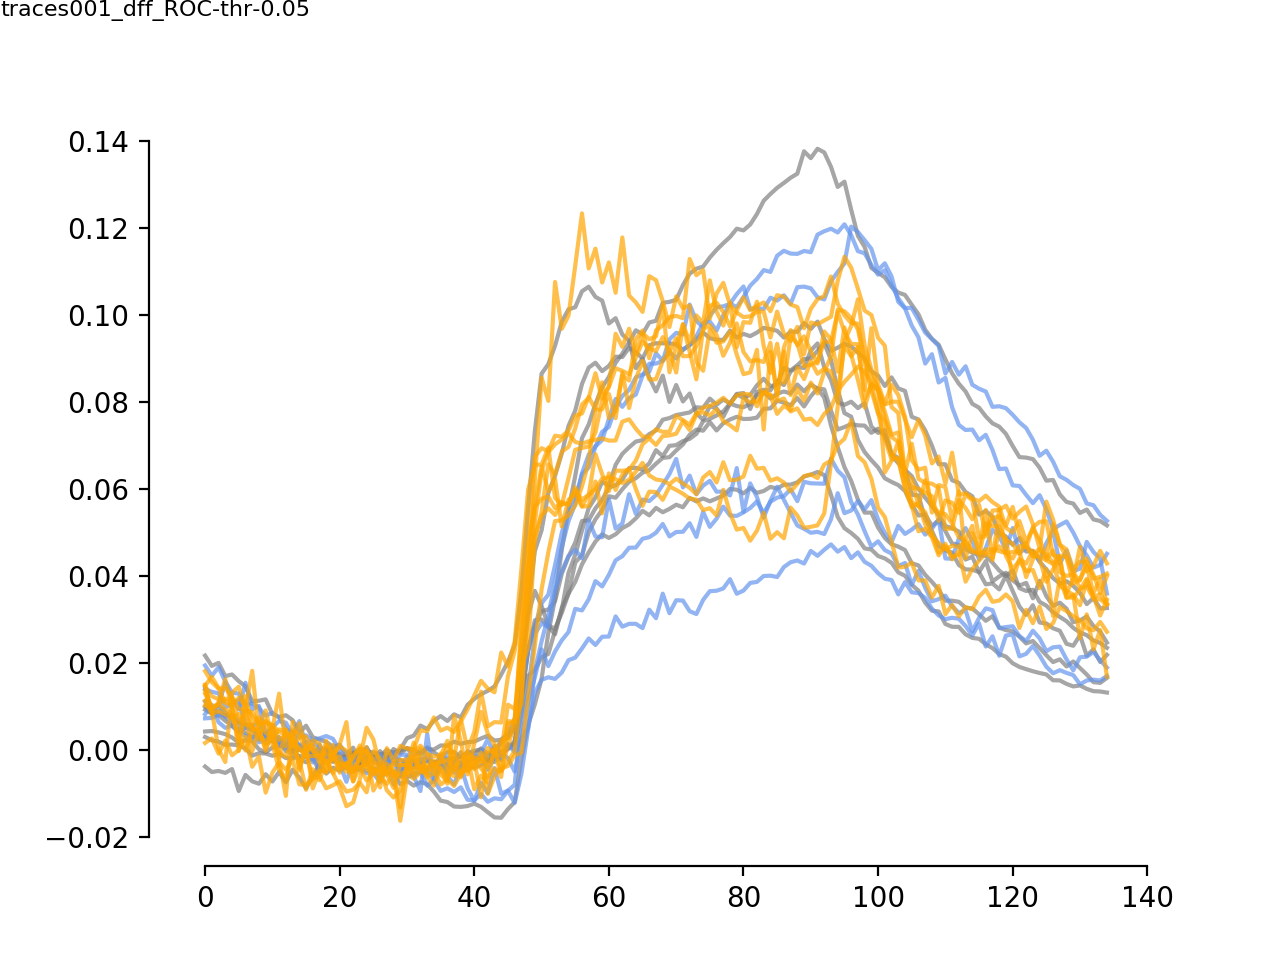

avg-timecourse-popn-each_overlap-thr-0.10_min-nrois-5_ROC_blobs


In [35]:
fig, ax = pl.subplots()
for visual_area, tmat in traces_by.items():
    for vs in tmat:
        ax.plot(vs, color=area_colors[visual_area], alpha=0.7)

sns.despine(trim=True, offset=4)
label_figure(fig, figid)
figname = 'avg-timecourse-popn-each_overlap-thr-%.2f_min-nrois-%i_%s_%s' % (overlap_thr, min_rois, responsive_test, curr_exp)
print(figname)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
pl.savefig(os.path.join(outdir, '%s.png' % figname))

#### Plot as mean +/- sem

<IPython.core.display.Javascript object>


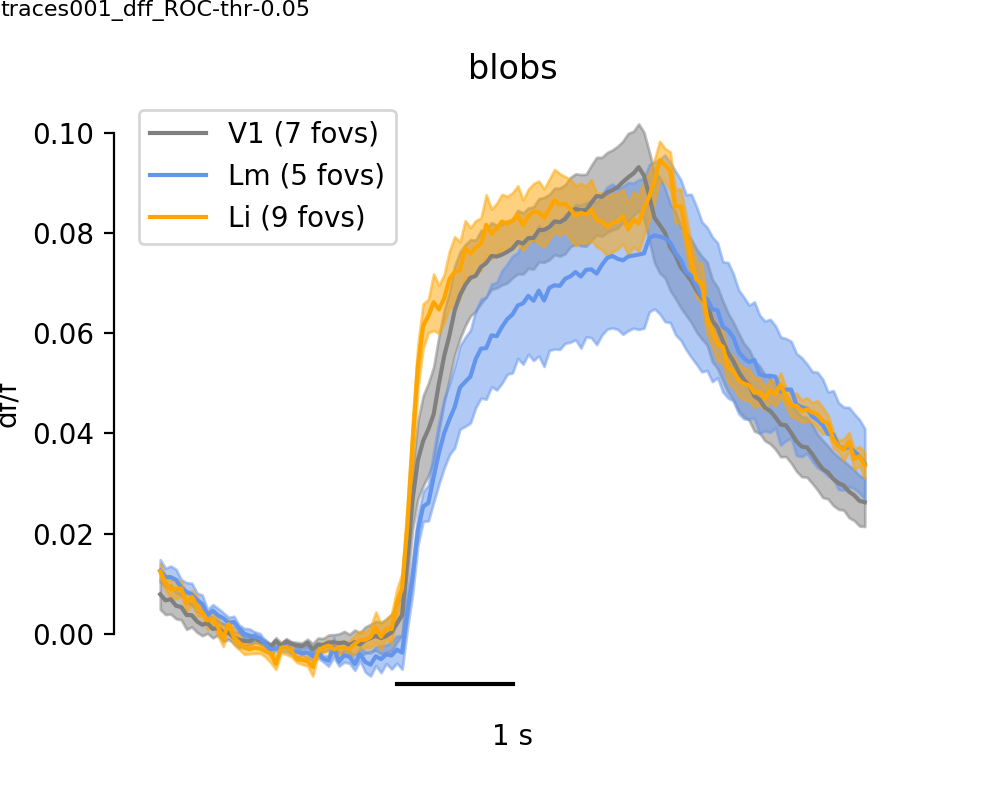

avg-timecourse-popn_overlap-thr-0.10_min-nrois-5_ROC_blobs


In [37]:
yval = -0.01
fig, ax = pl.subplots(figsize=(5, 4))
for visual_area, tmat in traces_by.items():
    meantrace = np.array(tmat).mean(axis=0)
    stdtrace = spstats.sem(np.array(tmat), axis=0)
    ax.plot(meantrace, color=area_colors[visual_area], alpha=1, 
            label='%s (%i fovs)' % (visual_area, len(tmat)))
    nt = len(meantrace)
    ax.fill_between(np.arange(0, nt), meantrace-stdtrace, meantrace+stdtrace, 
                    color=area_colors[visual_area], alpha=0.5)
ax.plot([stim_on, stim_on+nframes_on], [yval, yval], 'k')
ax.set_ylabel('df/f')
ax.set_xlabel('1 s')
ax.set_xticklabels([])
ax.set_xticks([])
sns.despine(bottom=True, offset=4, trim=True)
ax.legend()
ax.set_title(curr_exp)

label_figure(fig, figid)
figname = 'avg-timecourse-popn_overlap-thr-%.2f_min-nrois-%i_%s_%s' % (overlap_thr, min_rois, responsive_test, curr_exp)
print(figname)
pl.savefig(os.path.join(outdir, '%s.svg' % figname))
pl.savefig(os.path.join(outdir, '%s.png' % figname))

In [121]:
os.listdir(os.path.join(aggregate_dir, 'responsivity'))


['stats-traces001-corrected-dff-ROC-thr-0.05',
 'stats_old',
 'compare_ROC-vs-NSTDS.png',
 'stats-traces001-corrected-dff-nstds-thr-10.00',
 'compare_ROC-vs-NSTDS-by-experiment.png',
 'RManova-split-by-experiment_tmp2.png',
 'RManova-split-by-experiment_fraction-selective-p0.05.png',
 'RManova-split-by-experiment_fraction-visual-p0.05-of-selective-p0.05.png',
 'ROC-split-by-experiment_p-0.05-niters-1000.png',
 'RManova-split-by-experiment_fraction-selective-p0.01.png',
 'RManova-split-by-experiment_fraction-visual-p0.05-of-selective-p0.01.png',
 'RManova-split-by-experiment_fraction-visual-p0.05.png',
 'nstds-split-by-experiment_nstds-2.5-nframes-10.png',
 'RManova-split-by-experiment_fraction-visual-p0.01.png',
 'RManova-split-by-experiment_fraction-visual-p0.01-of-selective-p0.01.png',
 'ROC-split-by-experiment_p-0.05-niters-1000_box.png']

In [23]:
tdf[tdf['visual_area']=='Li'].groupby(['datakey']).count()

,trace,visual_area
datakey,,
20190502_JC076_fov1,135,135
20190602_JC091_fov1,135,135
20190605_JC090_fov1,135,135
20190606_JC091_fov1,135,135
20190607_JC091_fov1,135,135
20190609_JC099_fov1,135,135
20190612_JC099_fov1,135,135
20190614_JC091_fov1,135,135
20191008_JC091_fov1,135,135
